In [399]:
import boto3
import botocore.exceptions
import dateutil.parser
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker
import sys
import time

from datetime import datetime
from sagemaker import get_execution_role

%matplotlib inline
plt.style.use('Solarize_Light2')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# 1. Prepare the Datasets

In [401]:
df = pd.read_csv("daily_revenue.csv")
df.sort_values(by=['payment_date'])

,payment_date,payment_state,service_fee
8232,2017-12-01,NSW,15.909091
8233,2017-12-03,NSW,15.909091
73470,2017-12-03,NSW,15.909091
40659,2017-12-04,NSW,15.909091
73468,2017-12-05,NSW,15.909091
...,...,...,...
32394,2021-11-18,NSW,35.454545
32393,2021-11-18,QLD,14.772727
32392,2021-11-18,VIC,15.909091
32390,2021-11-18,QLD,35.454545


In [402]:
df['payment_state'].value_counts()

NSW    59588
VIC    31254
QLD    22407
WA     16526
SA        57
ACT       33
TAS       16
NT         1
Name: payment_state, dtype: int64

To enable the AWS's **Weather Index**, we have to provide geolocation of our records

In [403]:
def get_geolocation_by_state(state):
    if state == 'NSW':
        return '-33.8_151.2'
    elif state == 'VIC':
        return '-37.8_144.9'
    elif state == 'QLD':
        return '27.4_153'
    elif state == 'WA':
        return  '31.9_115.9'
    else:
        return 'error'

In [404]:
def get_df_by_state(state_name):
    tmp_df = df[df['payment_state'] == state_name]
    tmp_df = tmp_df.groupby(['payment_date']).sum()
    tmp_df.index = pd.to_datetime(tmp_df.index)
    tmp_df['item_id'] = state_name
    return tmp_df

nsw_df = get_df_by_state("NSW")
nsw_df.head()

,service_fee,item_id
payment_date,,
2017-12-01,15.909091,NSW
2017-12-03,31.818182,NSW
2017-12-04,15.909091,NSW
2017-12-05,106.590909,NSW
2017-12-06,159.090909,NSW


Take NSW as an example, let's plot a line chart to display revenue each day

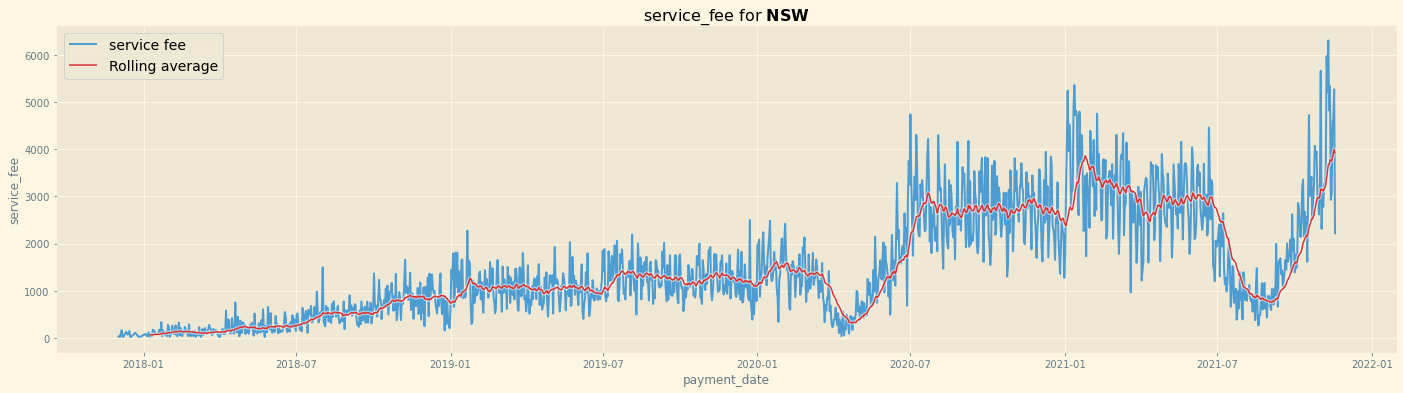

In [405]:
# nsw_df.plot(subplots=True)
daily_rolling_average = nsw_df['service_fee'].rolling(window=24).mean()

fig = plt.figure(figsize=(24,6))
plt.plot(nsw_df['service_fee'], alpha=0.8, label='service fee')

# Adding daily rolling average:
plt.plot(daily_rolling_average.index, daily_rolling_average, alpha=0.5, color='white', linewidth=4)
plt.plot(daily_rolling_average.index, daily_rolling_average, color=colors[5], linewidth=1.5, label='Rolling average')

plt.title(r'service_fee for $\bf{NSW}$', fontsize=16)
plt.xlabel('payment_date')
plt.ylabel('service_fee')
plt.legend(fontsize=14)
plt.show()

In [406]:
start_date = np.min(nsw_df.index)
end_date = np.max(nsw_df.index)
print(start_date)
print(end_date)

2017-12-01 00:00:00
2021-11-18 00:00:00


AWS can help us fill in the missing value automatically, but I still do it manually before handle over the dataset to AWS

In [407]:
def fill_in_zero(tmp_df, state):
    idx = pd.date_range(start_date, end_date)
    tmp_df = tmp_df.reindex(idx, fill_value=0)
    tmp_df.index.names = ['payment_date']
    tmp_df = tmp_df.reset_index()
    tmp_df['item_id'] = state
    tmp_df['location'] = get_geolocation_by_state(state)
    return tmp_df
nsw_df = fill_in_zero(nsw_df, 'NSW')
nsw_df


,payment_date,service_fee,item_id,location
0,2017-12-01,15.909091,NSW,-33.8_151.2
1,2017-12-02,0.000000,NSW,-33.8_151.2
2,2017-12-03,31.818182,NSW,-33.8_151.2
3,2017-12-04,15.909091,NSW,-33.8_151.2
4,2017-12-05,106.590909,NSW,-33.8_151.2
...,...,...,...,...
1444,2021-11-14,3054.577273,NSW,-33.8_151.2
1445,2021-11-15,4568.320455,NSW,-33.8_151.2
1446,2021-11-16,4681.895455,NSW,-33.8_151.2
1447,2021-11-17,5273.693182,NSW,-33.8_151.2


### VIC

In [409]:
vic_df = get_df_by_state("VIC")
vic_df

,service_fee,item_id
payment_date,,
2019-05-22,105.681818,VIC
2019-05-23,153.750000,VIC
2019-05-24,400.227273,VIC
2019-05-25,206.818182,VIC
2019-05-26,207.500000,VIC
...,...,...
2021-11-14,3462.145455,VIC
2021-11-15,5596.725000,VIC
2021-11-16,6126.495455,VIC


In [410]:
vic_df = fill_in_zero(vic_df, 'VIC')
vic_df

,payment_date,service_fee,item_id,location
0,2017-12-01,0.000000,VIC,-37.8_144.9
1,2017-12-02,0.000000,VIC,-37.8_144.9
2,2017-12-03,0.000000,VIC,-37.8_144.9
3,2017-12-04,0.000000,VIC,-37.8_144.9
4,2017-12-05,0.000000,VIC,-37.8_144.9
...,...,...,...,...
1444,2021-11-14,3462.145455,VIC,-37.8_144.9
1445,2021-11-15,5596.725000,VIC,-37.8_144.9
1446,2021-11-16,6126.495455,VIC,-37.8_144.9
1447,2021-11-17,4833.736364,VIC,-37.8_144.9


### QLD

In [412]:
qld_df = get_df_by_state("QLD")
qld_df = fill_in_zero(qld_df, 'QLD')
qld_df

,payment_date,service_fee,item_id,location
0,2017-12-01,0.000000,QLD,27.4_153
1,2017-12-02,0.000000,QLD,27.4_153
2,2017-12-03,0.000000,QLD,27.4_153
3,2017-12-04,0.000000,QLD,27.4_153
4,2017-12-05,0.000000,QLD,27.4_153
...,...,...,...,...
1444,2021-11-14,1166.306818,QLD,27.4_153
1445,2021-11-15,2783.238636,QLD,27.4_153
1446,2021-11-16,2425.227273,QLD,27.4_153
1447,2021-11-17,1825.227273,QLD,27.4_153


### WA

In [414]:
wa_df = get_df_by_state("WA")
wa_df = fill_in_zero(wa_df, 'WA')

### Concatenating data from each states

In [416]:
frames = [nsw_df, vic_df, qld_df, wa_df]
training_df = pd.concat(frames)
training_df.sort_values(by=['payment_date'])

,payment_date,service_fee,item_id,location
0,2017-12-01,15.909091,NSW,-33.8_151.2
0,2017-12-01,0.000000,QLD,27.4_153
0,2017-12-01,0.000000,WA,31.9_115.9
0,2017-12-01,0.000000,VIC,-37.8_144.9
1,2017-12-02,0.000000,NSW,-33.8_151.2
...,...,...,...,...
1447,2021-11-17,5273.693182,NSW,-33.8_151.2
1448,2021-11-18,1825.711364,VIC,-37.8_144.9
1448,2021-11-18,2196.045455,NSW,-33.8_151.2
1448,2021-11-18,965.000000,QLD,27.4_153


In [417]:
training_df.to_csv(f"aws_ready_data/train.csv", header=False, index=False)

# 2. AWS

In [418]:
region = 'ap-southeast-2'
bucket_name = 'ezlicence-sagemaker'

### IAM

In [420]:
# Create the role to provide to Amazon Forecast.
role_name = "AmazonForecast-ExecutionRole-xxxxxxxx"
role_arn = boto3.resource('iam').Role(role_name).arn

### Connect API session

In [422]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [423]:
## check you can communicate with Forecast API session
forecast.list_predictors()

{'Predictors': [],
 'ResponseMetadata': {'RequestId': 'bfdaf0dc-b334-40df-91bb-68908f9a5c65',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 19 Nov 2021 05:03:00 GMT',
   'x-amzn-requestid': 'bfdaf0dc-b334-40df-91bb-68908f9a5c65',
   'content-length': '17',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### s3

In [425]:
PREFIX = 'revenue_xxxxx'
KEY = f'{PREFIX}/train.csv'
boto3.Session().resource('s3').Bucket(bucket_name).Object(KEY).upload_file("aws_ready_data/train.csv")

### Creating the Dataset Group and Dataset

In [427]:
project = 'revenue_forecast_xxxx'
datasetName = project + '_ds'
datasetGroupName = project + '_dsg'
s3DataPath = "s3://" + bucket_name + "/" + KEY

In [428]:
create_dataset_group_response = forecast.create_dataset_group(
    DatasetGroupName=datasetGroupName,
    Domain="METRICS",
)
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

print(f'- Dataset group name: {datasetGroupName}')
print(f'- Dataset group ARN: {datasetGroupArn}')

- Dataset group name: service_fee_revenue_forecast_dsg
- Dataset group ARN: arn:aws:forecast:ap-southeast-2:106327405651:dataset-group/service_fee_revenue_forecast_dsg


In [429]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'service_fee_revenue_forecast_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:ap-southeast-2:106327405651:dataset-group/service_fee_revenue_forecast_dsg',
 'DatasetArns': [],
 'Domain': 'METRICS',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 11, 19, 15, 33, 5, 678000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 11, 19, 15, 33, 5, 678000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'ac16ed7c-c785-46c2-b371-dd09989a3df0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 19 Nov 2021 05:03:06 GMT',
   'x-amzn-requestid': 'ac16ed7c-c785-46c2-b371-dd09989a3df0',
   'content-length': '293',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create the Dataset for AWS Forecast

In [431]:
training_df.head()

,payment_date,service_fee,item_id,location
0,2017-12-01,15.909091,NSW,-33.8_151.2
1,2017-12-02,0.000000,NSW,-33.8_151.2
2,2017-12-03,31.818182,NSW,-33.8_151.2
3,2017-12-04,15.909091,NSW,-33.8_151.2
4,2017-12-05,106.590909,NSW,-33.8_151.2


In [432]:
schema = {
   "Attributes": [
      { "AttributeName": "timestamp",    "AttributeType": "timestamp" },
      { "AttributeName": "metric_value", "AttributeType": "float"     },
      { "AttributeName": "metric_name",      "AttributeType": "string"    },
      {"AttributeName": "location", "AttributeType": "geolocation"}
   ]
}

In [433]:
DATASET_FREQUENCY = "D" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [434]:
try:
    response = forecast.create_dataset(
        Domain='METRICS',
        DatasetType='TARGET_TIME_SERIES',
        DatasetName=datasetName,
        DataFrequency=DATASET_FREQUENCY, 
        Schema=schema
    )
    datasetArn = response['DatasetArn']
    
except Exception as e:
    error_code = e.response['Error']['Code']

    # If the dataset group already exists, we get its ARN:
    if (error_code == 'ResourceAlreadyExistsException'):
        print('A dataset with this name already exists, you can use it to ingest new data into it:')
        
        # List all the existing datasets:
        forecast_ds_list = forecast.list_datasets()
        print(forecast_ds_list)
        
        # Loop through all the Forecast datasets:
        for ds in forecast_ds_list['Datasets']:
            # Get the project name (the string after the first delimiter in the ARN)
            ds_name = ds['DatasetArn'].split('/')[1]

            # Once we find it, we store the ARN and break out of the loop:
            if (ds_name == datasetName):
                datasetArn = ds['DatasetArn']
                break
                
    else:
        raise


A dataset with this name already exists, you can use it to ingest new data into it:
{'Datasets': [{'DatasetArn': 'arn:aws:forecast:ap-southeast-2:106327405651:dataset/service_fee_revenue_forecast_ds', 'DatasetName': 'service_fee_revenue_forecast_ds', 'DatasetType': 'TARGET_TIME_SERIES', 'Domain': 'METRICS', 'CreationTime': datetime.datetime(2021, 11, 19, 15, 9, 2, 880000, tzinfo=tzlocal()), 'LastModificationTime': datetime.datetime(2021, 11, 19, 15, 32, 25, 232000, tzinfo=tzlocal())}, {'DatasetArn': 'arn:aws:forecast:ap-southeast-2:106327405651:dataset/lessons_top5_12Sep', 'DatasetName': 'lessons_top5_12Sep', 'DatasetType': 'TARGET_TIME_SERIES', 'Domain': 'RETAIL', 'CreationTime': datetime.datetime(2021, 9, 13, 17, 27, 39, 968000, tzinfo=tzlocal()), 'LastModificationTime': datetime.datetime(2021, 9, 13, 17, 36, 5, 437000, tzinfo=tzlocal())}], 'ResponseMetadata': {'RequestId': '5f70a79e-f873-4b04-9e9c-e223ca23ffcb', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-a

In [435]:
print(f'- Dataset name: {datasetName}')
print(f'- Dataset ARN: {datasetArn}')

- Dataset name: service_fee_revenue_forecast_ds
- Dataset ARN: arn:aws:forecast:ap-southeast-2:106327405651:dataset/service_fee_revenue_forecast_ds


In [436]:
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:ap-southeast-2:106327405651:dataset/service_fee_revenue_forecast_ds',
 'DatasetName': 'service_fee_revenue_forecast_ds',
 'Domain': 'METRICS',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'D',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'metric_value', 'AttributeType': 'float'},
   {'AttributeName': 'metric_name', 'AttributeType': 'string'},
   {'AttributeName': 'location', 'AttributeType': 'geolocation'}]},
 'EncryptionConfig': {},
 'Status': 'UPDATE_IN_PROGRESS',
 'CreationTime': datetime.datetime(2021, 11, 19, 15, 9, 2, 880000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 11, 19, 15, 32, 25, 232000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '970a19f6-7d38-41c2-87b1-a49dea231bd7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 19 Nov 2021 05:03:15 GMT',
   'x-amzn-requestid': '97

### Add Dataset to Dataset Group

In [438]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '2b4d6907-de00-4364-bbfd-353a6a2bb14b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 19 Nov 2021 05:03:20 GMT',
   'x-amzn-requestid': '2b4d6907-de00-4364-bbfd-353a6a2bb14b',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create Data Import Job

In [398]:
datasetImportJobName = 'service_fee_dataset_import_job'
ds_import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=datasetImportJobName,
    DatasetArn=datasetArn,
    DataSource= {
        "S3Config" : {
            "Path": s3DataPath,
            "RoleArn": role_arn
        }
    },
    TimestampFormat=TIMESTAMP_FORMAT,
    GeolocationFormat="LAT_LONG",
    UseGeolocationForTimeZone=True
)

In [440]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:ap-southeast-2:106327405651:dataset-import-job/service_fee_revenue_forecast_ds/service_fee_dataset_import_job


In [444]:
status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
print(str(pd.to_datetime(datetime.now()))[:19], "| Data ingestion:", status)

2021-11-19 15:36:56 | Data ingestion: ACTIVE


## with weather and holiday

In [449]:
# # Use default missing data filling see: https://docs.aws.amazon.com/forecast/latest/dg/howitworks-missing-values.html
# featurizations_no_weather = {"ForecastFrequency": DATASET_FREQUENCY }

# # For weather index, need to specify which column contains geolocation 
# # Use default missing data filling
featurizations_weather = {"ForecastFrequency": DATASET_FREQUENCY, 
                  "ForecastDimensions": ["location"] }

In [457]:
algorithm_arn = 'arn:aws:forecast:::algorithm/ARIMA'
forecast_horizon = 14
forecast_types = ["0.50", "0.70"]
predictor_name= project + '_arima'

# print(f'[{predictor_name_arima_revenue}] Creating predictor {predictor_name_arima_revenue} ...')

In [458]:
## Train a predictor with Holidays and Weather

create_predictor_response = forecast.create_predictor(
    PredictorName=predictor_name,
    AlgorithmArn=algorithm_arn,
    ForecastHorizon=forecast_horizon,
    ForecastTypes=forecast_types,
    PerformAutoML=False,
    PerformHPO=False,
    #       TrainingParameters=hyperparameters,
    EvaluationParameters= {"NumberOfBacktestWindows": 3, 
                         "BackTestWindowOffset": forecast_horizon}, 
    InputDataConfig = { 
        "DatasetGroupArn": datasetGroupArn,
        "SupplementaryFeatures": [ 
        { 
            "Name": "weather",
            "Value": "true"
        },
        { 
        "Name": "holiday",
        "Value": "AU"
        }]
    },                                                                                                         
    FeaturizationConfig= featurizations_weather
)

In [465]:
predictor_arn = create_predictor_response['PredictorArn']

### Create a Forecast

In [463]:
forecast_name = project + '_arima_forecast'

In [469]:
create_forecast_response = forecast.create_forecast(
    ForecastName=forecast_name,
    PredictorArn=predictor_arn
)
forecast_arn = create_forecast_response['ForecastArn']

In [468]:
print(f'- Forecast name: {forecastName}')
print(f'- Forecast ARN: {forecast_arn}')

- Forecast name: service_fee_revenue_forecast_arima_forecast
- Forecast ARN: arn:aws:forecast:ap-southeast-2:106327405651:forecast/service_fee_revenue_forecast_arima_forecast


In [471]:
status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
print(str(pd.to_datetime(datetime.now()))[:19], "| Forecast generation:", status)

2021-11-19 16:25:35 | Forecast generation: CREATE_IN_PROGRESS


# 3. Evaluating our forecast

In [528]:
metric_names = ['NSW', 'VIC', 'QLD', 'WA']
forecastResponses = dict()

In [529]:
metric_names = ['NSW', 'VIC', 'QLD', 'WA']

print(forecast_arn)
print()

# forecastResponses = []
for metric_name in metric_names:
    forecastResponse = forecastquery.query_forecast(
        ForecastArn=forecast_arn,
        Filters={'metric_name': metric_name}
    )
    forecastResponses[metric_name] = forecastResponse
print(forecastResponses)

arn:aws:forecast:ap-southeast-2:106327405651:forecast/service_fee_revenue_forecast_arima_forecast

{'NSW': {'Forecast': {'Predictions': {'p50': [{'Timestamp': '2021-11-19T00:00:00', 'Value': 3414.063109852905}, {'Timestamp': '2021-11-20T00:00:00', 'Value': 3216.1037804156317}, {'Timestamp': '2021-11-21T00:00:00', 'Value': 3507.254649301196}, {'Timestamp': '2021-11-22T00:00:00', 'Value': 4278.483862448786}, {'Timestamp': '2021-11-23T00:00:00', 'Value': 4145.578407710853}, {'Timestamp': '2021-11-24T00:00:00', 'Value': 4220.948340024503}, {'Timestamp': '2021-11-25T00:00:00', 'Value': 3944.16206821431}, {'Timestamp': '2021-11-26T00:00:00', 'Value': 3591.8515144622133}, {'Timestamp': '2021-11-27T00:00:00', 'Value': 3216.1037804156317}, {'Timestamp': '2021-11-28T00:00:00', 'Value': 3507.254649301196}, {'Timestamp': '2021-11-29T00:00:00', 'Value': 4278.483862448786}, {'Timestamp': '2021-11-30T00:00:00', 'Value': 4145.578407710853}, {'Timestamp': '2021-12-01T00:00:00', 'Value': 4220.9483400245

## Post-processing the prediction


In [531]:
def get_results_by_state(state):
    forecastResponse = forecastResponses[state]
    predictions_df = dict()
    for percentile in ['p50', 'p70']:
        predictions_df.update({percentile: pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions'][percentile])})
        predictions_df[percentile]['Timestamp'] = pd.to_datetime(predictions_df[percentile]['Timestamp'])
        predictions_df[percentile].columns = ['Timestamp', percentile]

    predictions_df['p50']

    results_df = pd.merge(predictions_df['p50'], predictions_df['p70'], how='inner', left_on=['Timestamp'], right_on='Timestamp')
    return results_df

results_df = get_results_by_state('NSW')
results_df.head()


,Timestamp,p50,p70
0,2021-11-19,3414.063110,3721.437889
1,2021-11-20,3216.103780,3538.910486
2,2021-11-21,3507.254649,3838.805501
3,2021-11-22,4278.483862,4618.554099
4,2021-11-23,4145.578408,4493.959756


In [516]:
actual_train_df = pd.read_csv("aws_ready_data/train.csv", names=['timestamp','service_fee','payment_state', 'locat'], parse_dates=[0])
actual_train_df = actual_train_df[actual_train_df['payment_state'] == 'NSW']


actual_train_df['timestamp'] = pd.to_datetime(actual_train_df['timestamp'])
actual_train_df = actual_train_df.set_index('timestamp')
actual_train_df


,service_fee,payment_state,locat
timestamp,,,
2017-12-01,15.909091,NSW,-33.8_151.2
2017-12-02,0.000000,NSW,-33.8_151.2
2017-12-03,31.818182,NSW,-33.8_151.2
2017-12-04,15.909091,NSW,-33.8_151.2
2017-12-05,106.590909,NSW,-33.8_151.2
...,...,...,...
2021-11-14,3054.577273,NSW,-33.8_151.2
2021-11-15,4568.320455,NSW,-33.8_151.2
2021-11-16,4681.895455,NSW,-33.8_151.2


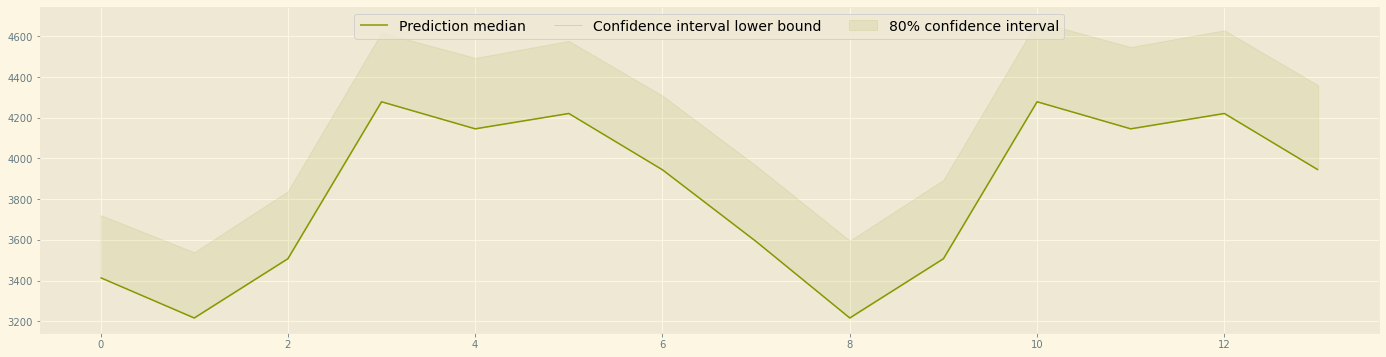

In [522]:
# First, plot the actual data during the evaluation period:
fig = plt.figure(figsize=(24,6))

# Next, plot the prediction enveloppe and the median value predicted:
plt.plot(results_df['p50'], label='Prediction median', color=colors[2], linewidth=1.5)
p50 = results_df['p50']
p70 = results_df['p70']
plt.fill_between(p50.index, p50, p70, color=colors[2], alpha=0.1, label='80% confidence interval')
plt.plot(results_df['p50'], label='Confidence interval lower bound', color=colors[2], linewidth=0.5, alpha=0.5)

# # Show the plot with a legend
plt.legend(fontsize=14, ncol=5, loc='upper center')
plt.show()

In [544]:
states = ['NSW', 'VIC', 'QLD', 'WA']
results_df = pd.DataFrame()
for state in states:
    tmp_df = get_results_by_state(state)
    tmp_df = tmp_df.rename(columns={"p50": "p50_"+state, "p70": "p70_"+state})
    if state == 'NSW':
        results_df = tmp_df
    else:
        results_df = pd.merge(left=results_df, 
               right=tmp_df, how='outer',
               left_on='Timestamp', right_on='Timestamp')    
results_df

,Timestamp,p50_NSW,p70_NSW,p50_VIC,p70_VIC,p50_QLD,p70_QLD,p50_WA,p70_WA
0,2021-11-19,3414.063110,3721.437889,2386.191646,2664.905422,1405.554161,1597.086290,1112.695400,1256.749012
1,2021-11-20,3216.103780,3538.910486,2221.838399,2550.655535,1347.293251,1547.797868,777.686534,923.945682
2,2021-11-21,3507.254649,3838.805501,3089.036188,3455.207873,1515.181619,1717.833696,799.454077,949.290261
3,2021-11-22,4278.483862,4618.554099,3881.262970,4270.080009,1968.578055,2172.494113,1349.613208,1502.632782
4,2021-11-23,4145.578408,4493.959756,3985.588609,4395.931847,2008.250778,2213.259965,1319.573935,1472.970712
5,2021-11-24,4220.948340,4577.447095,3391.873328,3824.214242,2036.957154,2243.018560,1341.472101,1495.245156
6,2021-11-25,3944.162068,4308.597468,2976.271972,3439.218576,1833.639783,2040.740245,1231.415706,1385.564120
7,2021-11-26,3591.851514,3964.054361,2350.328174,2844.803952,1616.809671,1824.942248,1128.942080,1283.464942
8,2021-11-27,3216.103780,3595.915257,2394.286947,2919.953943,1409.966995,1619.126200,897.114192,1052.010597
9,2021-11-28,3507.254649,3894.525299,2905.229831,3453.111807,1544.272964,1754.453693,969.917826,1125.186875


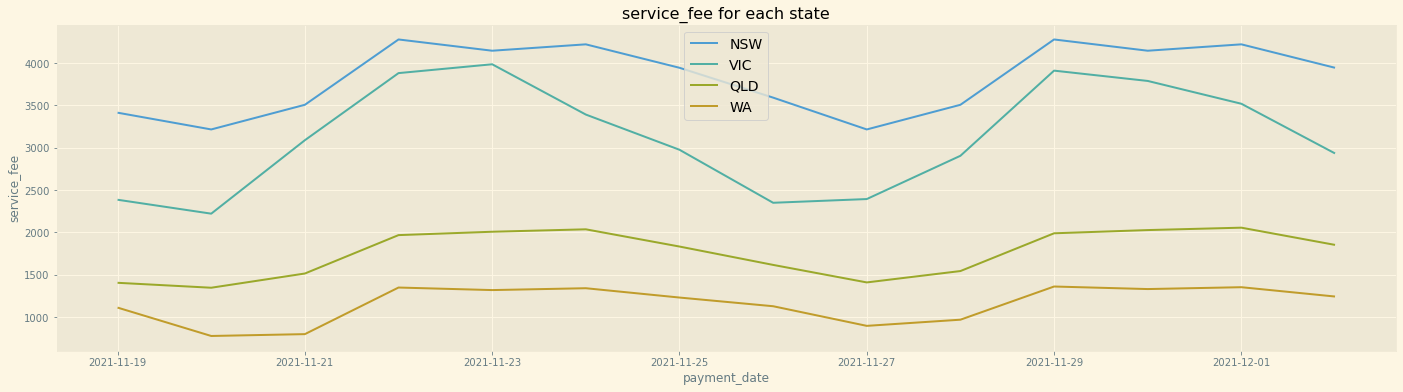

In [562]:
_ = results_df.set_index('Timestamp')

fig = plt.figure(figsize=(24,6))
for state in states:
    column = 'p50_'+state
    plt.plot(results_df['Timestamp'], results_df[column], alpha=0.8, label=state)

plt.title(r'service_fee for each state', fontsize=16)
plt.xlabel('payment_date')
plt.ylabel('service_fee')
plt.legend(fontsize=14)
plt.show()

In [563]:
service_fee_revenue_latest = pd.read_csv('service_fee_revenue_latest.csv')
service_fee_revenue_latest

,id,payment_date,booking_state,payment_state,instructor_payout,service_fee_gst,service_fee
0,5142138,2021-11-22,QLD,QLD,160.00,3.545455,35.454545
1,5142150,2021-11-22,VIC,VIC,47.25,1.431818,14.318182
2,5142157,2021-11-22,VIC,VIC,48.75,1.477273,14.772727
3,5142155,2021-11-22,NSW,NSW,212.50,5.136364,51.363636
4,5142163,2021-11-22,NSW,NSW,52.50,1.590909,15.909091
...,...,...,...,...,...,...,...
130863,85,2017-12-05,NSW,NSW,299.25,9.068182,90.681818
130864,84,2017-12-04,NSW,NSW,52.50,1.590909,15.909091
130865,82,2017-12-03,NSW,NSW,52.50,1.590909,15.909091
130866,81,2017-12-03,NSW,NSW,52.50,1.590909,15.909091


In [616]:
# state = 'NSW'
actual_revenue = pd.DataFrame()
for state in states:
    tmp_df = service_fee_revenue_latest.drop(columns=['id', 'booking_state', 'instructor_payout', 'service_fee_gst'])
    tmp_df = tmp_df[tmp_df['payment_state'] == state]
    tmp_df = tmp_df.drop(columns = ['payment_state'])
    tmp_df['payment_date'] = pd.to_datetime(tmp_df['payment_date'])
    tmp_df = tmp_df.groupby(['payment_date']).sum()
    start_time = pd.to_datetime('2021-11-19')
    end_time   = pd.to_datetime('2021-11-22')
    
    tmp_df = tmp_df.rename(columns={"service_fee": "service_fee_"+state})
    
    tmp_df = tmp_df[start_time:end_time]
    tmp_df = tmp_df.reset_index()
    
    if state == 'NSW':
        actual_revenue = tmp_df
    else:
        actual_revenue = pd.merge(left=actual_revenue,
                                  right=tmp_df, how='outer',
                                  left_on='payment_date', right_on='payment_date')  
        
actual_revenue       

,payment_date,service_fee_NSW,service_fee_VIC,service_fee_QLD,service_fee_WA
0,2021-11-19,3090.550000,3933.063636,1589.161364,1010.340909
1,2021-11-20,2444.261364,2946.250000,1721.829545,1140.113636
2,2021-11-21,4024.497727,2609.511364,1540.786364,1419.134091
3,2021-11-22,629.147727,209.318182,299.090909,15.909091


In [636]:
plot_df = pd.merge(left=actual_revenue,
                   right=results_df, how='left',
                   left_on='payment_date', right_on='Timestamp')  
plot_df = plot_df.drop(columns=['payment_date'])
plot_df

,service_fee_NSW,service_fee_VIC,service_fee_QLD,service_fee_WA,Timestamp,p50_NSW,p70_NSW,p50_VIC,p70_VIC,p50_QLD,p70_QLD,p50_WA,p70_WA
0,3090.550000,3933.063636,1589.161364,1010.340909,2021-11-19,3414.063110,3721.437889,2386.191646,2664.905422,1405.554161,1597.086290,1112.695400,1256.749012
1,2444.261364,2946.250000,1721.829545,1140.113636,2021-11-20,3216.103780,3538.910486,2221.838399,2550.655535,1347.293251,1547.797868,777.686534,923.945682
2,4024.497727,2609.511364,1540.786364,1419.134091,2021-11-21,3507.254649,3838.805501,3089.036188,3455.207873,1515.181619,1717.833696,799.454077,949.290261
3,629.147727,209.318182,299.090909,15.909091,2021-11-22,4278.483862,4618.554099,3881.262970,4270.080009,1968.578055,2172.494113,1349.613208,1502.632782


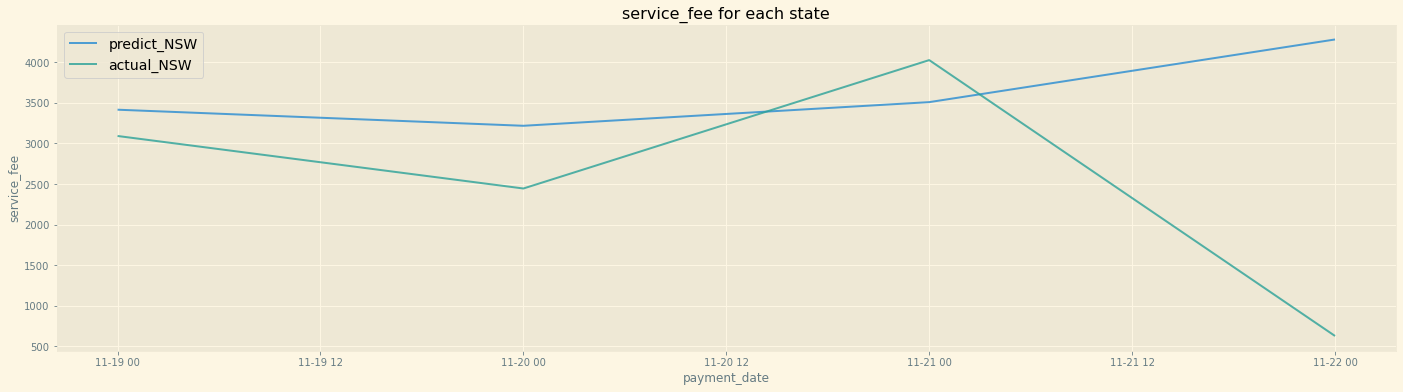

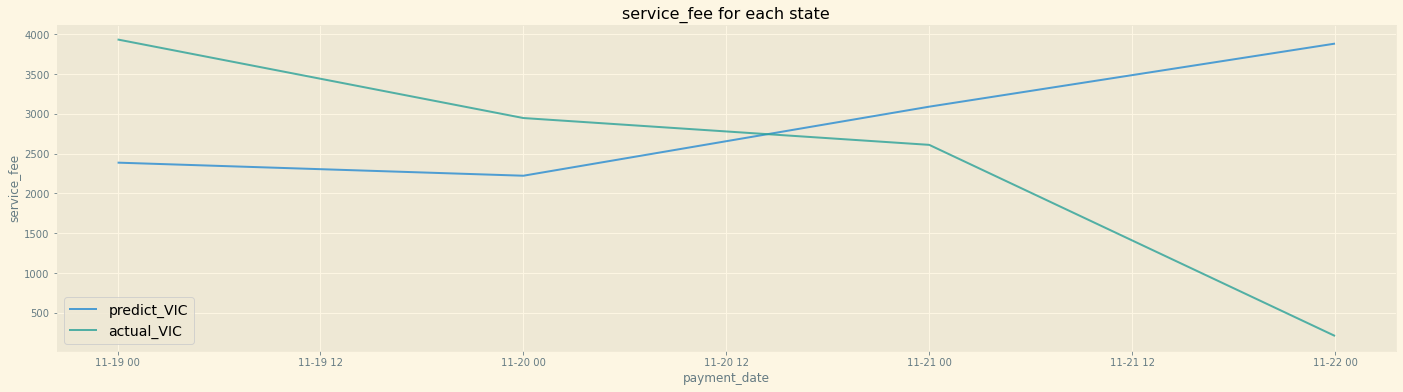

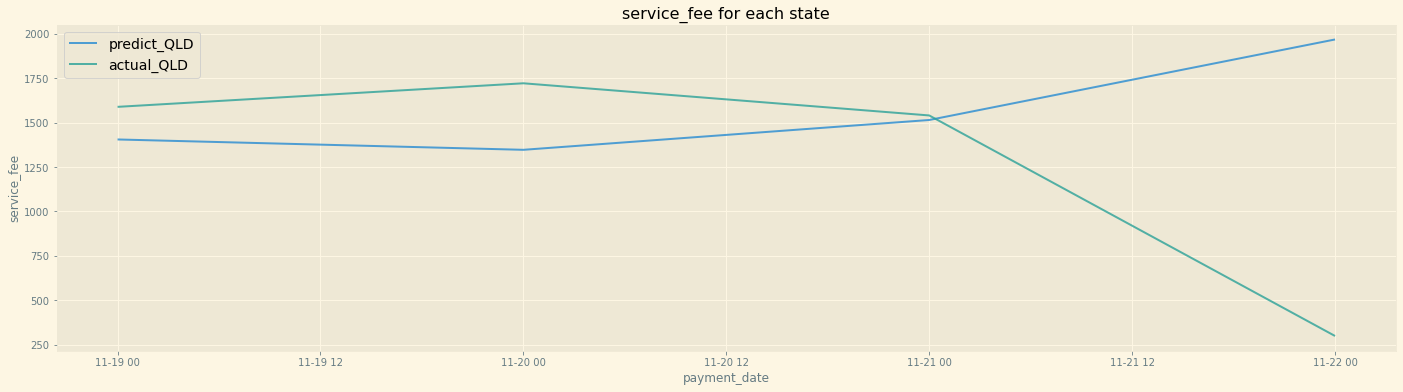

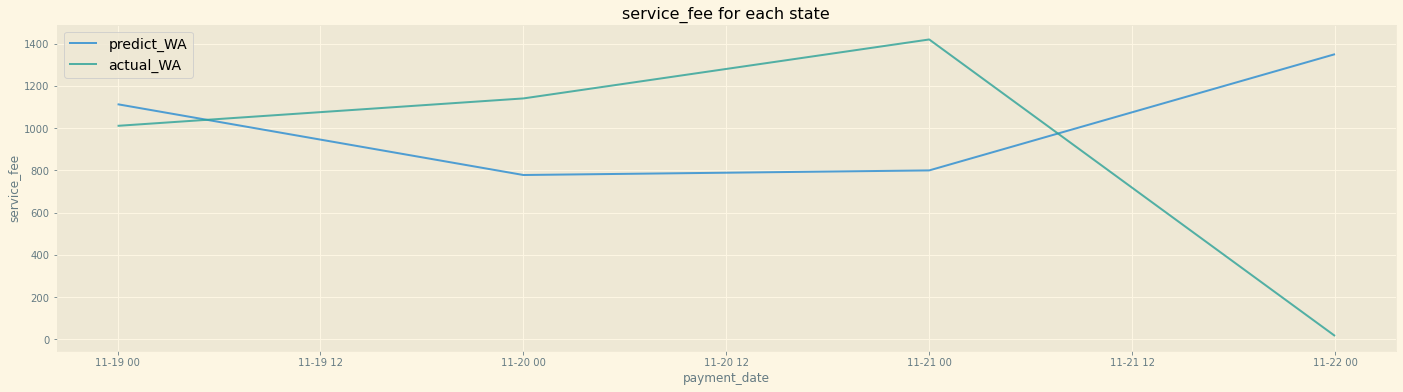

In [638]:
def evaluate_plot(state):
    fig = plt.figure(figsize=(24,6))
#     for state in states:
    predict_column = 'p50_'+state
    actual_column = 'service_fee_'+state

    plt.plot(plot_df['Timestamp'], plot_df[predict_column], alpha=0.8, label="predict_" + state)
    plt.plot(plot_df['Timestamp'], plot_df[actual_column], alpha=0.8, label="actual_" + state)

    plt.title(r'service_fee for each state', fontsize=16)
    plt.xlabel('payment_date')
    plt.ylabel('service_fee')
    plt.legend(fontsize=14)
    plt.show()

for state in states:
    evaluate_plot(state)
